# Dec 3, 2024, Jan 10, 2025: roi profile variability
nature of profiles: 
- localized/distributed: focused/distributed within modes?
- low/high variability across solution modes: consistent/variable between modes?

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import dill as pickle 
from os.path import join as pjoin
from itertools import product
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import subprocess
from scipy import sparse, stats
from scipy.spatial.distance import jensenshannon
from multiprocessing import Pool
import glob
import random

from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.utils import resample

import arviz as az

import ants
from nipype.interfaces import afni

from itertools import product, combinations, chain
import multiprocessing as mp
from functools import partial

# networks
import graph_tool.all as gt

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT
import colorcet as cc

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

def set_seed(args):
    gt.seed_rng(args.SEED)
    np.random.seed(args.SEED)

set_seed(args)

In [3]:
args.type = 'allen' #'spatial'
args.roi_size = 'x' #225
args.maintain_symmetry = True #True
args.brain_div = 'whl' #'whl'
args.num_rois = 172 #162

PARC_DESC = (
    f'type-{args.type}'
    f'_size-{args.roi_size}'
    f'_symm-{args.maintain_symmetry}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
)

In [4]:
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson-corr'
args.THRESHOLDING = f'positive'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 20
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'sub'

BASE_path = f'{os.environ["HOME"]}/mouse_dataset'
PARCELS_path = f'{BASE_path}/parcels'
ROI_path = f'{BASE_path}/roi_results_v2/{PARC_DESC}'
TS_path = f'{ROI_path}/runwise_timeseries'
ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLDING}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)
RSN_ROI_path = f'{ROI_path}/rsns'
os.system(f'mkdir -p {RSN_ROI_path}')
IC_ROI_path = f'{ROI_path}/ics'
os.system(f'mkdir -p {IC_ROI_path}')
GRAPH_path = f'{ROI_RESULTS_path}/graphs'
os.system(f'mkdir -p {GRAPH_path}')
SBM_path = f'{ROI_RESULTS_path}/model-fits'
os.system(f'mkdir -p {SBM_path}')
ESTIM_path = f'{ROI_RESULTS_path}/estimates'
os.system(f'mkdir -p {ESTIM_path}/individual')
os.system(f'mkdir -p {ESTIM_path}/group')

0

In [5]:
args.dc, args.sbm = False, 'h'

args.nested = True if args.sbm in ['h'] else False

args.force_niter = 40000
args.num_draws = int((1/2) * args.force_niter)

def sbm_name(args):
    dc = f'dc' if args.dc else f'nd'
    dc = f'' if args.sbm in ['m', 'a'] else dc
    file = f'sbm-{dc}-{args.sbm}'
    return file

SBM = sbm_name(args)
SBM

'sbm-nd-h'

In [6]:
def get_membership_matrix(num_rois, df, col='pi'):
    pis = [np.zeros((num_rois, 1)) if np.isnan(pi).all() else pi for pi in df[col]]

    num_modes = len(df)
    num_comms = np.max([pi.shape[-1] for pi in pis])
    num_rois = num_rois
    M = np.zeros((num_rois, num_modes, num_comms)) # membership profile matrix

    for idx_mode, pi in enumerate(pis):
        M[:, idx_mode, :pi.shape[-1]] = pi
    
    return M

In [7]:
marginals_files = sorted(glob.glob(f'{ESTIM_path}/individual/sub-*/partition-modes-group-aligned/{SBM}/desc-mem-mats.pkl', recursive=True))
marginals_df = []
for sbm_file in marginals_files:
    with open(f'{sbm_file}', 'rb') as f:
        row = pickle.load(f)
    marginals_df += [row]
marginals_df = pd.concat(marginals_df).reset_index(drop=True)
mode_ids = list(chain.from_iterable([list(range(count)) for count in marginals_df['sub'].value_counts().sort_index().to_list()]))
marginals_df['mode_id'] = mode_ids
marginals_df

,sub,sbm,pi_0,pi_1,pi_2,pi_3,pi_4,pi_5,pi_6,pi_7,pi_8,omega,mode_id
0,SLC01,sbm-nd-h,"[[0.9901153212520593, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.8813838550247117, 0.0032948929159802307, 0...","[[0.957166392092257, 0.026359143327841845, 0.0...","[[0.9868204283360791, 0.013179571663920923], [...","[[0.9983525535420099, 0.0016474464579901153], ...","[[0.9983525535420099, 0.0016474464579901153], ...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",NaN,NaN,0.607440,0
1,SLC01,sbm-nd-h,"[[0.9892857142857143, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.9142857142857143, 0.0, 0.0, 0.0, 0.0857142...","[[0.9357142857142857, 0.039285714285714285, 0....","[[0.9857142857142858, 0.014285714285714285], [...","[[0.9964285714285714, 0.0035714285714285713], ...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",NaN,NaN,NaN,0.280320,1
2,SLC01,sbm-nd-h,"[[0.16964285714285715, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.7142857142857143, 0.0, 0.0, 0.0, 0.25, 0.0...","[[0.9107142857142857, 0.07142857142857142, 0.0...","[[0.9910714285714286, 0.008928571428571428], [...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",NaN,NaN,NaN,NaN,0.112240,2
3,SLC02,sbm-nd-h,"[[0.9901153212520593, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.8813838550247117, 0.0032948929159802307, 0...","[[0.957166392092257, 0.026359143327841845, 0.0...","[[0.9868204283360791, 0.013179571663920923], [...","[[0.9983525535420099, 0.0016474464579901153], ...","[[0.9983525535420099, 0.0016474464579901153], ...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",NaN,NaN,0.505160,0
4,SLC02,sbm-nd-h,"[[0.9892857142857143, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.9142857142857143, 0.0, 0.0, 0.0, 0.0857142...","[[0.9357142857142857, 0.039285714285714285, 0....","[[0.9857142857142858, 0.014285714285714285], [...","[[0.9964285714285714, 0.0035714285714285713], ...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",NaN,NaN,NaN,0.338587,1
5,SLC02,sbm-nd-h,"[[0.16964285714285715, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.7142857142857143, 0.0, 0.0, 0.0, 0.25, 0.0...","[[0.9107142857142857, 0.07142857142857142, 0.0...","[[0.9910714285714286, 0.008928571428571428], [...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",NaN,NaN,NaN,NaN,0.156253,2
6,SLC03,sbm-nd-h,"[[0.9901153212520593, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.8813838550247117, 0.0032948929159802307, 0...","[[0.957166392092257, 0.026359143327841845, 0.0...","[[0.9868204283360791, 0.013179571663920923], [...","[[0.9983525535420099, 0.0016474464579901153], ...","[[0.9983525535420099, 0.0016474464579901153], ...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",NaN,NaN,0.161628,0
7,SLC03,sbm-nd-h,"[[0.9892857142857143, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.9142857142857143, 0.0, 0.0, 0.0, 0.0857142...","[[0.9357142857142857, 0.039285714285714285, 0....","[[0.9857142857142858, 0.014285714285714285], [...","[[0.9964285714285714, 0.0035714285714285713], ...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",NaN,NaN,NaN,0.155390,1
8,SLC03,sbm-nd-h,"[[0.16964285714285715, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.7142857142857143, 0.0, 0.0, 0.0, 0.25, 0.0...","[[0.9107142857142857, 0.07142857142857142, 0.0...","[[0.9910714285714286, 0.008928571428571428], [...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",NaN,NaN,NaN,NaN,0.143074,2
9,SLC03,sbm-nd-h,"[[0.9405940594059405, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.9821782178217822, 0.0, 0.0, 0.0, 0.0138613...","[[0.9465346534653465, 0.033663366336633666, 0....","[[0.9900990099009901, 0.009900990099009901, 0....","[[0.996039603960396, 0.0039603960396039604], [...","[[1.0, 0.0], [1.0, 0.0], [0.998019801980198, 0...","[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",NaN,0.124680,3


In [8]:
cols = [col for col in  list(marginals_df.columns) if 'pi_' in col]
cols

['pi_0', 'pi_1', 'pi_2', 'pi_3', 'pi_4', 'pi_5', 'pi_6', 'pi_7', 'pi_8']

In [9]:
# SOFT MARGINALS
soft_marginals_df = []
for sub, group in marginals_df.groupby('sub'):
    omegas = group['omega'].to_list()
    dct = {'sub': [sub], 'sbm': [SBM]}
    for col in cols:
        M = get_membership_matrix(args.num_rois, group, col=col)
        SCs = np.average(M, axis=1, weights=omegas) # soft-comms.
        dct[col] = [SCs]
    soft_marginals_df += [pd.DataFrame(dct)]
soft_marginals_df = pd.concat(soft_marginals_df).reset_index(drop=True)
soft_marginals_df

,sub,sbm,pi_0,pi_1,pi_2,pi_3,pi_4,pi_5,pi_6,pi_7,pi_8
0,SLC01,sbm-nd-h,"[[0.8977929364556366, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.8718518088962108, 0.0020014497528830313, 0...","[[0.9459391532125205, 0.035041312308778536, 0....","[[0.9869874867027537, 0.013012513297246411], [...","[[0.9979981322664156, 0.002001867733584373], [...","[[0.8867592751235585, 0.0010007248764415156], ...","[[0.60744], [0.60744], [0.60744], [0.60744], [...","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
1,SLC02,sbm-nd-h,"[[0.8616335531836663, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.866414497438449, 0.0016644494656771884, 0....","[[0.9426447281233193, 0.03777812415626341, 0.0...","[[0.9871101321431203, 0.012889867856879716], [...","[[0.9979585356708509, 0.0020414643291491565], ...","[[0.8429152750671455, 0.0008322247328385942], ...","[[0.5051604128330267], [0.5051604128330267], [...","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
2,SLC03,sbm-nd-h,"[[0.7347218143727945, 0.0, 0.01904950922275958...","[[0.8027296121914562, 0.09455013968026232, 0.0...","[[0.8805463280375332, 0.056739282130032, 0.0, ...","[[0.9787149023468772, 0.019748842924379402, 0....","[[0.9979020767759192, 0.0020979232240807954], ...","[[0.8163130106637612, 0.0006255689907493272], ...","[[0.5958893154190659, 0.0], [0.595350722336753...","[[0.2119321817018554, 0.0], [0.211393588619543...","[[0.08725207933461292], [0.08725207933461292],..."
3,SLC04,sbm-nd-h,"[[0.9459125043909121, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.8863237124765099, 0.0017297001457630258, 0...","[[0.9456396553691001, 0.03421771912783523, 0.0...","[[0.9865813022905506, 0.01341869770944947], [0...","[[0.9976294804485735, 0.002370519551426652], [...","[[0.9456865981588357, 0.0008648500728815129], ...","[[0.5249639942390784], [0.5249639942390784], [...","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
4,SLC05,sbm-nd-h,"[[0.8130407774443612, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.874092392812236, 0.0012080019852788717, 0....","[[0.9404885581915815, 0.040065316915495336, 0....","[[0.9880332791031377, 0.011966249222332899, 2....","[[0.9977904353375576, 0.002209564662442389], [...","[[0.7951267313386685, 0.0006040009926394359], ...","[[0.5538055644387593, 0.0], [0.553805564438759...","[[0.18724016629357212], [0.18724016629357212],...","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
5,SLC06,sbm-nd-h,"[[0.8973256100813988, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.8729552523304034, 0.0018802736107749298, 0...","[[0.9451368866106166, 0.03553384231794725, 0.0...","[[0.9869496611469873, 0.013050338853012768], [...","[[0.9979292773923479, 0.002070722607652064], [...","[[0.8862869286988916, 0.0009401368053874649], ...","[[0.5706630408701912], [0.5706630408701912], [...","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
6,SLC07,sbm-nd-h,"[[0.916710109513164, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.8846781446861861, 0.0014928319833808522, 0...","[[0.9436751094882899, 0.03600391625820136, 0.0...","[[0.9868477994721776, 0.01315172866466849, 2.3...","[[0.9975946356212689, 0.002405364378731002], [...","[[0.9125543918144361, 0.0007464159916904261], ...","[[0.49172198672318645, 0.0], [0.49172198672318...","[[0.03871070942973686], [0.03871070942973686],...","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
7,SLC08,sbm-nd-h,"[[0.8483587803360707, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.8785646411340852, 0.0013375125218844722, 0...","[[0.9419809372493975, 0.03843527216566195, 0.0...","[[0.9877036299233776, 0.012296370076622522, 0....","[[0.9977338981828051, 0.0022661018171949614], ...","[[0.8359973771577107, 0.0006687562609422361], ...","[[0.5576707726763718, 0.0], [0.557670772676371...","[[0.1517357222844345], [0.1517357222844345], [...","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
8,SLC09,sbm-nd-h,"[[0.8244173424603205, 0.0, 0.0, 0.0, 0.0, 0.0,..

entropies

In [10]:
def mem_entropy(pi):
    if isinstance(pi, np.ndarray):
        ent = stats.entropy(pi, base=2, axis=-1) / np.log2(pi.shape[-1])
        ent = np.nan_to_num(ent)
    elif np.isnan(pi):
        ent = np.zeros((args.num_rois,))
    return ent

In [11]:
marginals_ent_df = pd.concat(
    [
        marginals_df[['sub', 'sbm']],
        marginals_df[cols].applymap(mem_entropy), 
        marginals_df[['omega', 'mode_id']],
    ],
    axis=1
)
marginals_ent_df

,sub,sbm,pi_0,pi_1,pi_2,pi_3,pi_4,pi_5,pi_6,pi_7,pi_8,omega,mode_id
0,SLC01,sbm-nd-h,"[0.016309240223030902, 0.00916545314727682, 0....","[0.14673370186330292, 0.039781753071329654, 0....","[0.11462830586862423, 0.11387517223865742, 0.1...","[0.10120195917086722, 0.09078713994277972, 0.1...","[0.017606357022390016, 0.03191389907613702, 0....","[0.017606357022390016, 0.017606357022390016, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.607440,0
1,SLC01,sbm-nd-h,"[0.015957299438629644, 0.011421545373632498, 0...","[0.09934268311962276, 0.07178996639723381, 0.1...","[0.15714124901042995, 0.13844516514327337, 0.1...","[0.10802319526362833, 0.08549206159572127, 0.0...","[0.034176424086597386, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.280320,1
2,SLC01,sbm-nd-h,"[0.12260956759622385, 0.0, 0.0, 0.0, 0.0, 0.19...","[0.26748877266338517, 0.13302521352210017, 0.3...","[0.19286120610267837, 0.08599151075641316, 0.0...","[0.07360348308562405, 0.07360348308562405, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.112240,2
3,SLC02,sbm-nd-h,"[0.016309240223030902, 0.00916545314727682, 0....","[0.14673370186330292, 0.039781753071329654, 0....","[0.11462830586862423, 0.11387517223865742, 0.1...","[0.10120195917086722, 0.09078713994277972, 0.1...","[0.017606357022390016, 0.03191389907613702, 0....","[0.017606357022390016, 0.017606357022390016, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.505160,0
4,SLC02,sbm-nd-h,"[0.015957299438629644, 0.011421545373632498, 0...","[0.09934268311962276, 0.07178996639723381, 0.1...","[0.15714124901042995, 0.13844516514327337, 0.1...","[0.10802319526362833, 0.08549206159572127, 0.0...","[0.034176424086597386, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.338587,1
5,SLC02,sbm-nd-h,"[0.12260956759622385, 0.0, 0.0, 0.0, 0.0, 0.19...","[0.26748877266338517, 0.13302521352210017, 0.3...","[0.19286120610267837, 0.08599151075641316, 0.0...","[0.07360348308562405, 0.07360348308562405, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.156253,2
6,SLC03,sbm-nd-h,"[0.016309240223030902, 0.00916545314727682, 0....","[0.14673370186330292, 0.039781753071329654, 0....","[0.11462830586862423, 0.11387517223865742, 0.1...","[0.10120195917086722, 0.09078713994277972, 0.1...","[0.017606357022390016, 0.03191389907613702, 0....","[0.017606357022390016, 0.017606357022390016, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.161628,0
7,SLC03,sbm-nd-h,"[0.015957299438629644, 0.011421545373632498, 0...","[0.09934268311962276, 0.07178996639723381, 0.1...","[0.15714124901042995, 0.13844516514327337, 0.1...","[0.10802319526362833, 0.08549206159572127, 0.0...","[0.034176424086597386, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 

In [12]:
soft_marginals_ent_df = pd.concat(
    [
        soft_marginals_df[['sub', 'sbm']],
        soft_marginals_df[cols].applymap(mem_entropy)
    ],
    axis=1,
)
soft_marginals_ent_df

,sub,sbm,pi_0,pi_1,pi_2,pi_3,pi_4,pi_5,pi_6,pi_7,pi_8
0,SLC01,sbm-nd-h,"[0.08883778069031498, 0.008483119040316367, 0....","[0.1498323304753846, 0.061909274024402196, 0.2...","[0.13694069599141392, 0.11852606611044703, 0.1...","[0.10016023053039701, 0.0874210063184817, 0.09...","[0.02083081037706876, 0.02082706456043096, 0.0...","[0.012664465603784104, 0.012664465603784104, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,SLC02,sbm-nd-h,"[0.1082480660240817, 0.008355626013618316, 0.0...","[0.15282270155678052, 0.06757498201269041, 0.2...","[0.14312454700894472, 0.11890592788297584, 0.1...","[0.09939345489400299, 0.08636646812598772, 0.0...","[0.021185094701366484, 0.017763392419325803, 0...","[0.01127154290459909, 0.01127154290459909, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,SLC03,sbm-nd-h,"[0.2197220074044, 0.2542222610380889, 0.188163...","[0.24291327659637918, 0.2630715446682154, 0.27...","[0.21500736521408317, 0.33202102777572734, 0.3...","[0.05619608364153657, 0.09194581664563324, 0.0...","[0.021688336694764863, 0.06412786694995742, 0....","[0.009030453667609488, 0.017579170718000095, 0...","[0.0, 0.010442761283174888, 0.0104427612831748...","[0.0, 0.025568616921261122, 0.0255686169212611...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,SLC04,sbm-nd-h,"[0.05665141648577146, 0.009330834507971687, 0....","[0.1364686933174221, 0.06093747453476385, 0.18...","[0.13785096876413816, 0.12367284751818006, 0.1...","[0.10268770379358871, 0.08766446151226345, 0.0...","[0.024088187823570553, 0.018363722985841414, 0...","[0.01054214664018535, 0.01054214664018535, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,SLC05,sbm-nd-h,"[0.13103943712669483, 0.1290512075544686, 0.04...","[0.1466266344289316, 0.19048634419477659, 0.21...","[0.11979847597354287, 0.1269365542557895, 0.14...","[0.03333177662047428, 0.03673279375029434, 0.0...","[0.022677031994652642, 0.023653940810508374, 0...","[0.008961110461623772, 0.008958039182928446, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,SLC06,sbm-nd-h,"[0.08911090939678963, 0.008592869227014611, 0....","[0.14842141256071525, 0.06308133419379898, 0.2...","[0.13851845477589725, 0.11945839996105644, 0.1...","[0.10039637312146606, 0.08721959372825472, 0.0...","[0.02144616401600182, 0.019735689385883232, 0....","[0.01199946229754674, 0.01199946229754674, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,SLC07,sbm-nd-h,"[0.07751309238264643, 0.04749572333760632, 0.0...","[0.13729181218191708, 0.10022976061732582, 0.1...","[0.11540112445054714, 0.10768615696936025, 0.1...","[0.035991036697900845, 0.032364221689382675, 0...","[0.024391567104180334, 0.018304709315359095, 0...","[0.009561275423445622, 0.00955862602160274, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,SLC08,sbm-nd-h,"[0.11564843427245781, 0.11428323776350022, 0.0...","[0.14308233400191567, 0.1734361442250495, 0.20...","[0.11768419235935504, 0.12265383301862616, 0.1...","[0.060353813656823206, 0.06339072562905261, 0....","[0.023174586546234745, 0.022935568141141147, 0...","[0.00937677403589463, 0.00937677403589463, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,SLC09,sbm-nd-h,"[0.12635169770201504, 0.12525757540787807, 0.0..

In [13]:
entropies_df = []
for sub, group in marginals_ent_df.groupby('sub'):
    for col in cols:
        omegas = group['omega'].to_numpy()
        Hs = np.stack(group[col].to_list(), axis=-1)
        avg_H = Hs @ omegas
        H_mix = soft_marginals_ent_df[soft_marginals_ent_df['sub'] == sub][col].to_list()[0]
        del_H = H_mix - avg_H
        row = pd.DataFrame(dict(
            sub=[sub],
            sbm=[SBM],
            col=[col],
            average_H=[avg_H],
            H_mixture=[H_mix],
            delta_H=[del_H],
        ))
        entropies_df += [row]
entropies_df = pd.concat(entropies_df).reset_index(drop=True)

In [14]:
entropies_df

,sub,sbm,col,average_H,H_mixture,delta_H
0,SLC01,sbm-nd-h,pi_0,"[0.028141732926714718, 0.008769150458918493, 0...","[0.08883778069031498, 0.008483119040316367, 0....","[0.060696047763600255, -0.000286031418602126, ..."
1,SLC01,sbm-nd-h,pi_1,"[0.14700260063567572, 0.059219941431841595, 0....","[0.1498323304753846, 0.061909274024402196, 0.2...","[0.002829729839708889, 0.0026893325925606004, ..."
2,SLC01,sbm-nd-h,pi_2,"[0.13532639481240546, 0.11763297048491228, 0.1...","[0.13694069599141392, 0.11852606611044703, 0.1...","[0.0016143011790084594, 0.0008930956255347455,..."
3,SLC01,sbm-nd-h,pi_3,"[0.10001643511658233, 0.08737412993488515, 0.0...","[0.10016023053039701, 0.0874210063184817, 0.09...","[0.00014379541381467909, 4.687638359654467e-05..."
4,SLC01,sbm-nd-h,pi_4,"[0.020275140709635573, 0.01938577885480867, 0....","[0.02083081037706876, 0.02082706456043096, 0.0...","[0.0005556696674331868, 0.0014412857056222902,..."
...,...,...,...,...,...,...
85,SLC10,sbm-nd-h,pi_4,"[0.02029780103709933, 0.042712405998953, 0.042...","[0.021533055380772225, 0.053437841248653375, 0...","[0.0012352543436728938, 0.010725435249700377, ..."
86,SLC10,sbm-nd-h,pi_5,"[0.008365233567256294, 0.01108665766513059, 0....","[0.01088009192230459, 0.015773152783528303, 0....","[0.0025148583550482963, 0.004686495118397714, ..."
87,SLC10,sbm-nd-h,pi_6,"[0.0, 0.0031743842339437027, 0.003174384233943...","[0.0, 0.006926507156150555, 0.0069265071561505...","[0.0, 0.0037521229222068526, 0.003752122922206..."
88,SLC10,sbm-nd-h,pi_7,"[0.0, 0.0031743842339437027, 0.003174384233943...","[0.0, 0.022859452081613323, 0.0228594520816133...","[0.0, 0.01968506784766962, 0.01968506784766962..."


In [15]:
for sub, group in entropies_df.groupby('sub'):
    folder = f'{ESTIM_path}/individual/sub-{sub}/consistency-of-comm-assignments/{SBM}'
    os.system(f'mkdir -p {folder}')
    with open(f'{folder}/desc-entropies.pkl', 'wb') as f:
        pickle.dump(group, f)

nature of variability/consistency

In [16]:
def get_kmeans_threshold(data):
    kmeans = KMeans(n_clusters=2).fit(data.reshape(-1,1))
    centers = kmeans.cluster_centers_.flatten()
    return np.mean(centers)

def get_membership_variability_type(avg_H, del_H, avg_H_thresh, del_H_thresh):
    var_types = np.stack([avg_H > avg_H_thresh, del_H > del_H_thresh], axis=-1) @ [2, 1] # converting a base 2 number to base 10 number.
    var_types = var_types.reshape(-1, 1)
    var_types = OneHotEncoder(sparse_output=False, categories=[np.array([0, 1, 2, 3])]).fit_transform(var_types)
    return var_types

def get_var_types_per_sub(sub, group, avg_H_thresh=0.15, del_H_thresh=0.15):
    dct = {'sub':[sub], 'sbm':[SBM]}
    for idx, row in group.iterrows():
        col = row['col']
        avg_H, del_H = row[['average_H', 'delta_H']]
        avg_H_thresh = get_kmeans_threshold(avg_H)
        del_H_thresh = get_kmeans_threshold(del_H)
        var_types = get_membership_variability_type(
            avg_H, del_H, avg_H_thresh, del_H_thresh
        )
        dct[col] = [var_types]
    return pd.DataFrame(dct)

In [17]:
var_types_df = []
for sub, group in entropies_df.groupby('sub'):
    row = get_var_types_per_sub(sub, group)
    var_types_df += [row]
var_types_df = pd.concat(var_types_df).reset_index(drop=True)

In [18]:
var_types_df

,sub,sbm,pi_0,pi_1,pi_2,pi_3,pi_4,pi_5,pi_6,pi_7,pi_8
0,SLC01,sbm-nd-h,"[[0.0, 1.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...","[[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0], [...","[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], [...","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [..."
1,SLC02,sbm-nd-h,"[[0.0, 1.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...","[[0.0, 0.0, 1.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [...","[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], [...","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [..."
2,SLC03,sbm-nd-h,"[[0.0, 0.0, 1.0, 0.0], [0.0, 1.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0], [...","[[0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0], [...","[[1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0], [...","[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0], [...","[[1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0], [...","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [..."
3,SLC04,sbm-nd-h,"[[0.0, 1.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [...","[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], [...","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [..."
4,SLC05,sbm-nd-h,"[[0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...","[[0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...","[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], [...","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [..."
5,SLC06,sbm-nd-h,"[[0.0, 1.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [...","[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], [...","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [..."
6,SLC07,sbm-nd-h,"[[0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...","[[0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...","[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], [...","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [..."
7,SLC08,sbm-nd-h,"[[0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...","[[0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...","[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], [...","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [..."
8,SLC09,sbm-nd-h,"[[0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [..

In [19]:
for idx, row in entropies_df.iterrows():
    if not (row['sub'] == 'SLC01' and row['col'] == 'pi_0'): continue
    avg_H, del_H = row[['average_H', 'delta_H']]

<Axes: ylabel='Density'>

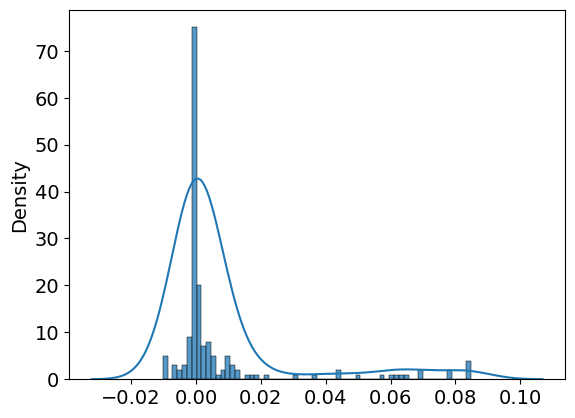

In [20]:
data = del_H
sns.kdeplot(data)
sns.histplot(data)

In [21]:
for idx, row in var_types_df.iterrows():
    sub = row['sub']
    folder = f'{ESTIM_path}/individual/sub-{sub}/consistency-of-comm-assignments/{SBM}'
    os.system(f'mkdir -p {folder}')
    with open(f'{folder}/desc-var-types.pkl', 'wb') as f:
        pickle.dump(row, f)

save individual level estimates

In [22]:
parcels_img = ants.image_read(f'{PARCELS_path}/{PARC_DESC}_desc-parcels.nii.gz')
parcels = parcels_img.numpy()
roi_labels = np.loadtxt(f'{PARCELS_path}/{PARC_DESC}_desc-labels.txt')

In [23]:
def concatenate(in_files, out_file):
    try:
        os.remove(out_file)
    except:
        pass

    tcat = afni.TCat()
    tcat.inputs.in_files = in_files
    tcat.inputs.out_file = out_file
    tcat.inputs.rlt = ''
    tcat.cmdline 
    tcat.run()

    for file in in_files:
        try:
            os.remove(file)
        except:
            pass
    return None

def ents_to_nifti(args, X, folder, ent_names, col=f'col'):
    os.system(f'mkdir -p {folder}')
    in_files = []
    for idx_ent in range(X.shape[-1]):
        x = X[:, idx_ent]
        x_img = np.zeros_like(parcels)
        for idx, roi in enumerate(roi_labels):
            x_img += (parcels == roi) * (x[idx])
        
        file = f'{folder}/ent-{ent_names[idx_ent]}.nii.gz'
        parcels_img.new_image_like(x_img).to_filename(file)
        in_files.append(file)
    
    out_file = f'{folder}/{col}_desc-entropies.nii.gz'
    concatenate(in_files, out_file)
    return None

def var_types_to_nifti(args, X, folder, col=f'col'):
    os.system(f'mkdir -p {folder}')
    in_files = []
    for idx_type in range(0, 4):
        x = X[:, idx_type]
        x_img = np.zeros_like(parcels)
        for idx, roi in enumerate(roi_labels):
            x_img += (parcels == roi) * (x[idx])
        
        file = f'{folder}/vartype-{idx_type:01d}.nii.gz'
        parcels_img.new_image_like(x_img).to_filename(file)
        in_files.append(file)

    out_file = f'{folder}/{col}_desc-var-types.nii.gz'
    concatenate(in_files, out_file)
    return None

In [24]:
# save all entropies per animal
for idx_row, row in entropies_df.iterrows():
    sub, col = row[['sub', 'col']]

    out_folder = f'{ESTIM_path}/individual/sub-{sub}/consistency-of-comm-assignments/{SBM}/nii'
    os.system(f'mkdir -p {out_folder}')

    Hs = np.stack(row[['average_H', 'H_mixture', 'delta_H']], axis=-1)
    ents_to_nifti(
        args, Hs, 
        out_folder, 
        ent_names=['avgH', 'Hmix', 'delH'],
        col=col,
    )
    # break

250226-12:29:05,145 nipype.interface INFO:
	 stderr 2025-02-26T12:29:05.145011:++ 3dTcat: AFNI version=AFNI_20.2.18 (Sep 17 2020) [64-bit]
250226-12:29:05,148 nipype.interface INFO:
	 stderr 2025-02-26T12:29:05.147956:*+ WARNING: can't apply -rlt option -- Not enough points per input dataset.
250226-12:29:05,150 nipype.interface INFO:
	 stderr 2025-02-26T12:29:05.150255:*+ WARNING: Set TR of output dataset to 1.0 s
250226-12:29:05,196 nipype.interface INFO:
	 stderr 2025-02-26T12:29:05.196549:++ elapsed time = 0.1 s
250226-12:29:05,625 nipype.interface INFO:
	 stderr 2025-02-26T12:29:05.625077:++ 3dTcat: AFNI version=AFNI_20.2.18 (Sep 17 2020) [64-bit]
250226-12:29:05,627 nipype.interface INFO:
	 stderr 2025-02-26T12:29:05.627783:*+ WARNING: can't apply -rlt option -- Not enough points per input dataset.
250226-12:29:05,630 nipype.interface INFO:
	 stderr 2025-02-26T12:29:05.630168:*+ WARNING: Set TR of output dataset to 1.0 s
250226-12:29:05,679 nipype.interface INFO:
	 stderr 2025-02

In [25]:
# save all var_types per animal
for idx, row in var_types_df.iterrows():
    sub = row['sub']

    out_folder = f'{ESTIM_path}/individual/sub-{sub}/consistency-of-comm-assignments/{SBM}/nii'
    os.system(f'mkdir -p {out_folder}')

    for col in cols:
        X = row[col]
        var_types_to_nifti(args, X, out_folder, col=col)
        # break
    # break

250226-12:29:47,805 nipype.interface INFO:
	 stderr 2025-02-26T12:29:47.805378:++ 3dTcat: AFNI version=AFNI_20.2.18 (Sep 17 2020) [64-bit]
250226-12:29:47,808 nipype.interface INFO:
	 stderr 2025-02-26T12:29:47.808761:*+ WARNING: can't apply -rlt option -- Not enough points per input dataset.
250226-12:29:47,811 nipype.interface INFO:
	 stderr 2025-02-26T12:29:47.811298:*+ WARNING: Set TR of output dataset to 1.0 s
250226-12:29:47,864 nipype.interface INFO:
	 stderr 2025-02-26T12:29:47.864895:++ elapsed time = 0.1 s
250226-12:29:48,340 nipype.interface INFO:
	 stderr 2025-02-26T12:29:48.339914:++ 3dTcat: AFNI version=AFNI_20.2.18 (Sep 17 2020) [64-bit]
250226-12:29:48,343 nipype.interface INFO:
	 stderr 2025-02-26T12:29:48.343237:*+ WARNING: can't apply -rlt option -- Not enough points per input dataset.
250226-12:29:48,345 nipype.interface INFO:
	 stderr 2025-02-26T12:29:48.345808:*+ WARNING: Set TR of output dataset to 1.0 s
250226-12:29:48,392 nipype.interface INFO:
	 stderr 2025-02

group level aggregation

In [26]:
# entropies

In [27]:
def bootstrap(matrices, n_bootstrap=1000):
    stacked = np.stack(matrices)
    bootstrap_means = np.stack([
        np.mean(resample(stacked), axis=0)
        for _ in range(n_bootstrap)
    ])
    return (
        np.mean(bootstrap_means, axis=0), # mean := probability of var type per roi
        np.percentile(bootstrap_means, [2.5, 97.5], axis=0) # CI
    )

In [28]:
group_ents_df = []
grp_cols = ['average_H', 'H_mixture', 'delta_H']
for col, group in entropies_df.groupby('col'):
    dct = {'sbm':[SBM], 'col':[col]}
    for grp_col in grp_cols:
        Hs = group[grp_col].to_list()
        mean_H, ci = bootstrap(Hs, n_bootstrap=100)
        dct[f'{grp_col}_mean'] = [mean_H]
        dct[f'{grp_col}_cil'] = [ci[0]]
        dct[f'{grp_col}_ciu'] = [ci[1]]
    row = pd.DataFrame(dct)
    group_ents_df += [row]
group_ents_df = pd.concat(group_ents_df).reset_index(drop=True)

In [29]:
group_ents_df

,sbm,col,average_H_mean,average_H_cil,average_H_ciu,H_mixture_mean,H_mixture_cil,H_mixture_ciu,delta_H_mean,delta_H_cil,delta_H_ciu
0,sbm-nd-h,pi_0,"[0.045205063753928944, 0.01862924049924233, 0....","[0.032038161823146324, 0.011138500336245078, 0...","[0.05739626085720797, 0.02627618371287011, 0.0...","[0.11914786024206991, 0.09147544263540539, 0.0...","[0.09409234263720562, 0.044026391465292476, 0....","[0.1502988453762878, 0.14750320043009896, 0.08...","[0.07575462575800217, 0.07750780705097399, 0.0...","[0.061577697721535686, 0.034675826136124833, 0...","[0.09308001289797693, 0.1244726051952823, 0.04..."
1,sbm-nd-h,pi_1,"[0.14282153681613324, 0.0734748917721598, 0.20...","[0.13808411790242583, 0.06302278133632183, 0.1...","[0.1466744975238392, 0.08635996952601777, 0.20...","[0.16127816764156677, 0.14015910994961123, 0.2...","[0.14433684334044908, 0.1006006976149769, 0.20...","[0.18422917401704542, 0.19036100719751614, 0.2...","[0.018521451813277242, 0.0671630389314403, 0.0...","[0.004637947905222687, 0.03129614547346442, 0....","[0.04045271386152964, 0.10223627102904095, 0.0..."
2,sbm-nd-h,pi_2,"[0.1520653860144107, 0.14923596319186222, 0.16...","[0.1377923511245315, 0.12431883125940767, 0.13...","[0.17547479555720036, 0.18698284190901382, 0.1...","[0.14268813011047338, 0.15831307234135988, 0.1...","[0.12439579817787287, 0.1189798549351753, 0.13...","[0.1624355806889852, 0.20190669509967046, 0.20...","[-0.00946694156543999, 0.008022282750721182, 0...","[-0.01570742199922716, -0.009195026595219811, ...","[-0.003928491635759102, 0.02749505807860968, 0..."
3,sbm-nd-h,pi_3,"[0.09840467910460571, 0.09654154525077482, 0.1...","[0.09482369558770407, 0.08804017925749336, 0.0...","[0.1023138378470011, 0.1084223810646456, 0.113...","[0.06967058224963875, 0.0710873857014604, 0.07...","[0.05194472045217444, 0.05713081405790448, 0.0...","[0.08328929962220985, 0.08218615735866486, 0.0...","[-0.029670836968522064, -0.02654608035177234, ...","[-0.04384047002638547, -0.038925209999458664, ...","[-0.014368217385814884, -0.012911399277891691,..."
4,sbm-nd-h,pi_4,"[0.02144771232360398, 0.02501297214719286, 0.0...","[0.020773859248747778, 0.018536332122795204, 0...","[0.022296809833459153, 0.031294812720520745, 0...","[0.02231398198813783, 0.027841502187983144, 0....","[0.021738456601718505, 0.019934672992049728, 0...","[0.02289519421023048, 0.039760792959821226, 0....","[0.0008402482283805866, 0.0038585611322529, 0....","[0.0006839746247932505, 0.0017512677191270057,...","[0.0010679852175318016, 0.006798948011477999, ..."
5,sbm-nd-h,pi_5,"[0.008270724498690603, 0.009028467625605302, 0...","[0.007519805061574323, 0.008193922620939416, 0...","[0.009012481185558602, 0.010008262218137609, 0...","[0.010488428011279062, 0.011753832689379353, 0...","[0.009683405159066507, 0.010450986401522653, 0...","[0.01123543376942378, 0.013637035636053353, 0....","[0.002169391551600892, 0.0027610648089114766, ...","[0.0018740100847246743, 0.0019959876733760327,...","[0.0023941471166311736, 0.0034883953074463262,..."
6,sbm-nd-h,pi_6,"[0.0, 0.0007366605125537946, 0.000736660512553...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.002053221295398335, 0.0020532212953983...","[0.0, 0.0016118257107302421, 0.001611825710730...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.003473853687865089, 0.0034738536878650...","[0.0, 0.0008734537786141093, 0.000873453778614...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0021927444640076977, 0.002192744464007..."
7,sbm-nd-h,pi_7,"[0.0, 0.0007142372537828877, 0.000714237253782...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0015066518592776093, 0.001506651859277...","[0.0, 0.004439127359226559, 0.0044391273592265...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.009827844954656396, 0.0098278449546563...","[0.0, 0.004396479021392738, 0.0043964790213927...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.010365503669648822, 0.0103655036696488.

In [30]:
folder = f'{ESTIM_path}/group/consistency-of-comm-assignments/{SBM}'
os.system(f'mkdir -p {folder}')
with open(f'{folder}/desc-entropies.pkl', 'wb') as f:
    pickle.dump(group_ents_df, f)

In [31]:
for idx, row in group_ents_df.iterrows():
    out_folder = f'{ESTIM_path}/group/consistency-of-comm-assignments/{SBM}/nii'
    os.system(f'mkdir -p {out_folder}')

    Hs = np.stack(row[['average_H_mean', 'H_mixture_mean', 'delta_H_mean']], axis=-1)
    ents_to_nifti(
        args, Hs, 
        out_folder, 
        ent_names=['avgH', 'Hmix', 'delH'],
        col=row['col'],
    )

250226-12:30:36,111 nipype.interface INFO:
	 stderr 2025-02-26T12:30:36.111205:++ 3dTcat: AFNI version=AFNI_20.2.18 (Sep 17 2020) [64-bit]
250226-12:30:36,113 nipype.interface INFO:
	 stderr 2025-02-26T12:30:36.113856:*+ WARNING: can't apply -rlt option -- Not enough points per input dataset.
250226-12:30:36,116 nipype.interface INFO:
	 stderr 2025-02-26T12:30:36.116333:*+ WARNING: Set TR of output dataset to 1.0 s
250226-12:30:36,163 nipype.interface INFO:
	 stderr 2025-02-26T12:30:36.163648:++ elapsed time = 0.1 s
250226-12:30:36,569 nipype.interface INFO:
	 stderr 2025-02-26T12:30:36.569584:++ 3dTcat: AFNI version=AFNI_20.2.18 (Sep 17 2020) [64-bit]
250226-12:30:36,572 nipype.interface INFO:
	 stderr 2025-02-26T12:30:36.572362:*+ WARNING: can't apply -rlt option -- Not enough points per input dataset.
250226-12:30:36,574 nipype.interface INFO:
	 stderr 2025-02-26T12:30:36.574869:*+ WARNING: Set TR of output dataset to 1.0 s
250226-12:30:36,625 nipype.interface INFO:
	 stderr 2025-02

In [32]:
# var_types

In [33]:
group_vartypes_df = []
for col in cols:
    var_types = var_types_df[col].to_list()
    mean_vts, ci_vts = bootstrap(var_types, n_bootstrap=100)
    row = pd.DataFrame(dict(
        sbm=[SBM],
        col=[col],
        var_type_mean=[mean_vts],
        var_type_cil=[ci_vts[0]],
        var_type_ciu=[ci_vts[1]],
    ))
    group_vartypes_df += [row]
group_vartypes_df = pd.concat(group_vartypes_df).reset_index(drop=True)

In [34]:
group_vartypes_df

,sbm,col,var_type_mean,var_type_cil,var_type_ciu
0,sbm-nd-h,pi_0,"[[0.10999999999999989, 0.787, 0.10299999999999...","[[0.0, 0.5, 0.0, 0.0], [0.1, 0.3, 0.0, 0.0], [...","[[0.3, 1.0, 0.3, 0.0], [0.7, 0.9, 0.0, 0.0], [..."
1,sbm-nd-h,pi_1,"[[0.8970000000000004, 0.0, 0.10299999999999995...","[[0.7, 0.0, 0.0, 0.0], [0.1, 0.3, 0.0, 0.0], [...","[[1.0, 0.0, 0.3, 0.0], [0.7, 0.9, 0.0, 0.0], [..."
2,sbm-nd-h,pi_2,"[[1.0, 0.0, 0.0, 0.0], [0.7859999999999999, 0....","[[1.0, 0.0, 0.0, 0.0], [0.4475, 0.0, 0.0, 0.0]...","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.55249..."
3,sbm-nd-h,pi_3,"[[0.524, 0.47600000000000003, 0.0, 0.0], [0.40...","[[0.3, 0.2, 0.0, 0.0], [0.1, 0.2, 0.0, 0.0], [...","[[0.8, 0.7, 0.0, 0.0], [0.7, 0.852499999999999..."
4,sbm-nd-h,pi_4,"[[0.89, 0.0, 0.10999999999999989, 0.0], [0.421...","[[0.6, 0.0, 0.0, 0.0], [0.14750000000000002, 0...","[[1.0, 0.0, 0.4, 0.0], [0.7, 0.5, 0.0, 0.6], [..."
5,sbm-nd-h,pi_5,"[[0.19300000000000003, 0.0999999999999999, 0.0...","[[0.0, 0.0, 0.0, 0.4475], [0.0, 0.0, 0.0, 0.54...","[[0.4, 0.3, 0.0, 1.0], [0.0, 0.452499999999999..."
6,sbm-nd-h,pi_6,"[[1.0, 0.0, 0.0, 0.0], [0.8059999999999999, 0....","[[1.0, 0.0, 0.0, 0.0], [0.6, 0.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.4], [..."
7,sbm-nd-h,pi_7,"[[1.0, 0.0, 0.0, 0.0], [0.799, 0.0, 0.0, 0.201...","[[1.0, 0.0, 0.0, 0.0], [0.5475, 0.0, 0.0, 0.0]...","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.45249..."
8,sbm-nd-h,pi_8,"[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [..."


In [35]:
folder = f'{ESTIM_path}/group/consistency-of-comm-assignments/{SBM}'
os.system(f'mkdir -p {folder}')
with open(f'{folder}/desc-var-types.pkl', 'wb') as f:
    pickle.dump(group_vartypes_df, f)

In [36]:
for idx, row in group_vartypes_df.iterrows():
    out_folder = f'{ESTIM_path}/group/consistency-of-comm-assignments/{SBM}/nii'
    os.system(f'mkdir -p {out_folder}')

    var_types = row['var_type_mean']
    var_types_to_nifti(
        args, var_types, 
        out_folder, 
        col=row['col'],
    )

250226-12:30:40,973 nipype.interface INFO:
	 stderr 2025-02-26T12:30:40.973011:++ 3dTcat: AFNI version=AFNI_20.2.18 (Sep 17 2020) [64-bit]
250226-12:30:40,976 nipype.interface INFO:
	 stderr 2025-02-26T12:30:40.976465:*+ WARNING: can't apply -rlt option -- Not enough points per input dataset.
250226-12:30:40,979 nipype.interface INFO:
	 stderr 2025-02-26T12:30:40.979068:*+ WARNING: Set TR of output dataset to 1.0 s
250226-12:30:41,33 nipype.interface INFO:
	 stderr 2025-02-26T12:30:41.033125:++ elapsed time = 0.1 s
250226-12:30:41,505 nipype.interface INFO:
	 stderr 2025-02-26T12:30:41.505578:++ 3dTcat: AFNI version=AFNI_20.2.18 (Sep 17 2020) [64-bit]
250226-12:30:41,508 nipype.interface INFO:
	 stderr 2025-02-26T12:30:41.508882:*+ WARNING: can't apply -rlt option -- Not enough points per input dataset.
250226-12:30:41,511 nipype.interface INFO:
	 stderr 2025-02-26T12:30:41.511380:*+ WARNING: Set TR of output dataset to 1.0 s
250226-12:30:41,569 nipype.interface INFO:
	 stderr 2025-02-

variability-types/profiles-nature per ic

In [37]:
col = cols[0]
col

'pi_0'

In [38]:
out_folder = f'{ESTIM_path}/individual/sub-*/consistency-of-comm-assignments/{SBM}/nii'
nii_files = sorted(glob.glob(f'{out_folder}/{col}_desc-var-types.nii.gz'))
nii_files

['/home/govindas/mouse_dataset/roi_results_v2/type-allen_size-x_symm-True_braindiv-whl_nrois-172/graph-constructed/method-pearson-corr/threshold-positive/edge-binary/density-20/layer-individual/unit-sub/estimates/individual/sub-SLC01/consistency-of-comm-assignments/sbm-nd-h/nii/pi_0_desc-var-types.nii.gz',
 '/home/govindas/mouse_dataset/roi_results_v2/type-allen_size-x_symm-True_braindiv-whl_nrois-172/graph-constructed/method-pearson-corr/threshold-positive/edge-binary/density-20/layer-individual/unit-sub/estimates/individual/sub-SLC02/consistency-of-comm-assignments/sbm-nd-h/nii/pi_0_desc-var-types.nii.gz',
 '/home/govindas/mouse_dataset/roi_results_v2/type-allen_size-x_symm-True_braindiv-whl_nrois-172/graph-constructed/method-pearson-corr/threshold-positive/edge-binary/density-20/layer-individual/unit-sub/estimates/individual/sub-SLC03/consistency-of-comm-assignments/sbm-nd-h/nii/pi_0_desc-var-types.nii.gz',
 '/home/govindas/mouse_dataset/roi_results_v2/type-allen_size-x_symm-True_br

In [39]:
ic_files = sorted(glob.glob(f'{IC_ROI_path}/*-mask*.nii.gz', recursive=True))
ics_df = pd.read_csv(f'{IC_ROI_path}/ic_names.csv')
ic_files

['/home/govindas/mouse_dataset/roi_results_v2/type-allen_size-x_symm-True_braindiv-whl_nrois-172/ics/desc-j-00-mask.nii.gz',
 '/home/govindas/mouse_dataset/roi_results_v2/type-allen_size-x_symm-True_braindiv-whl_nrois-172/ics/desc-j-01-mask.nii.gz',
 '/home/govindas/mouse_dataset/roi_results_v2/type-allen_size-x_symm-True_braindiv-whl_nrois-172/ics/desc-j-02-mask.nii.gz',
 '/home/govindas/mouse_dataset/roi_results_v2/type-allen_size-x_symm-True_braindiv-whl_nrois-172/ics/desc-j-03-mask.nii.gz',
 '/home/govindas/mouse_dataset/roi_results_v2/type-allen_size-x_symm-True_braindiv-whl_nrois-172/ics/desc-j-04-mask.nii.gz',
 '/home/govindas/mouse_dataset/roi_results_v2/type-allen_size-x_symm-True_braindiv-whl_nrois-172/ics/desc-j-05-mask.nii.gz',
 '/home/govindas/mouse_dataset/roi_results_v2/type-allen_size-x_symm-True_braindiv-whl_nrois-172/ics/desc-j-06-mask.nii.gz',
 '/home/govindas/mouse_dataset/roi_results_v2/type-allen_size-x_symm-True_braindiv-whl_nrois-172/ics/desc-j-07-mask.nii.gz',


In [40]:
def get_voxel_fractions(nii_vol, sys_vol):
    out_vol = nii_vol * sys_vol[..., np.newaxis]
    sys_size = np.count_nonzero(sys_vol)
    out_sizes = np.count_nonzero(out_vol, axis=(0, 1, 2))
    return out_sizes / sys_size

In [41]:
def get_voxel_fractions_all_sys(sys_files, ics_df, nii_files, ):
    vox_fracs_df = []
    for sys_file, (idx, row) in zip(sys_files, ics_df.iterrows()):
        sys_name = row['abbrev']

        X = []
        for nii_file in nii_files:
            sub = [s for s in nii_file.split('/') if 'sub-' in s][0].split('-')[-1]
            vox_fracs = get_voxel_fractions(
                nii_vol=ants.image_read(nii_file).numpy(), 
                sys_vol=ants.image_read(sys_file).numpy(),
            )
            X += [vox_fracs]
        X = np.stack(X)
        df = pd.DataFrame({
            'animal': np.repeat(np.arange(1, len(nii_files)+1), 4),
            'var_type': np.tile(['(lms, lsv)', '(lms, hsv)', '(dms, lsv)', '(dms, hsv)'], len(nii_files)),
            'frac': X.flatten(),
        })
        vox_fracs_df += [
            pd.DataFrame(dict(
                sys=[sys_name],
                vox_fracs=[X],
                df=[df],
            ))
        ]
    vox_fracs_df = pd.concat(vox_fracs_df).reset_index(drop=True)
    return vox_fracs_df

In [42]:
vox_fracs_df = get_voxel_fractions_all_sys(ic_files, ics_df, nii_files)
vox_fracs_df

,sys,vox_fracs,df
0,Pir,"[[0.812929061784897, 0.11956521739130435, 0.03...",animal var_type frac 0 1 (...
1,M1,"[[0.7702265372168284, 0.0, 0.2297734627831715,...",animal var_type frac 0 1 (...
2,S1(ULp) + S2,"[[0.5889714509190458, 0.0, 0.41102854908095426...",animal var_type frac 0 1 (...
3,S1(HL+FL),"[[0.7529411764705882, 0.013903743315508022, 0....",animal var_type frac 0 1 (...
4,S1(FL+BF),"[[0.7551379917792131, 0.023487962419260128, 0....",animal var_type frac 0 1 (...
5,S1(BF),"[[0.7087880528431936, 0.0, 0.2125215393452039,...",animal var_type frac 0 1 (...
6,V2+RSD,"[[0.7692806221646143, 0.15294880103694103, 0.0...",animal var_type frac 0 1 (...
7,Au(d+v),"[[0.6580441640378549, 0.00694006309148265, 0.0...",animal var_type frac 0 1 (...
8,Cg2,"[[0.8098186643078283, 0.11764705882352941, 0.0...",animal var_type frac 0 1 (...
9,Cg1 + RS,"[[0.9326805385556916, 0.0018359853121175031, 0...",animal var_type frac 0 1 (...


In [43]:
# plot the types
def plot_var_types_all_sys(col, vox_fracs_df):
    ncols = 5
    nrows = np.ceil(len(vox_fracs_df) / ncols).astype(int)
    fig, axs = plt.subplots(nrows, ncols, figsize=(6*ncols, 4*nrows))
    fig.tight_layout(h_pad=3, w_pad=3)
    fig.suptitle(f'{SBM} {col}', x=0.0, y=1.0)

    full_labels = [
        'lms: localized membership per solution mode', 'dms: distributed membership per solution mode', 
        'lsv: low solution variability', 'hsv: high solution variability'
    ]
    handles = [plt.Line2D([], [], marker='_', color='w', markersize=12, label=label) for label in full_labels]

    for idx_sys, row in vox_fracs_df.iterrows():
        r, c = idx_sys // ncols, idx_sys % ncols
        ax = axs[r, c] if nrows > 1 else axs[c]
        row = vox_fracs_df.iloc[idx_sys]
        X = row['vox_fracs']
        df = row['df']

        mean_X, ci = bootstrap([X[i, :] for i in range(X.shape[0])])

        sns.boxplot(df, x='var_type', y='frac', ax=ax, orient='v', color='grey', fill=False, fliersize=0, width=0.3, legend='brief')
        sns.stripplot(df, x='var_type', y='frac', ax=ax, orient='v', color='cornflowerblue', jitter=False)

        ax.plot(range(4), X[0, :], c='grey', alpha=0.3, label='animal')
        ax.plot(range(4), X[1:, :].T, c='grey', alpha=0.3)
        
        ax.plot(range(4), mean_X, c='cornflowerblue', label='mean')
        ax.fill_between(
            range(4),
            y1=ci[0],
            y2=ci[1],
            color='cornflowerblue',
            alpha=0.3,
            label=f'95% CI',
        )

        ax.set(title=f'IC: {row["sys"]}', ylim=[0, 1])
        ax.grid(alpha=0.15)
        ax.legend()

    for c_ in range(c+1, ncols):
        ax = axs[r, c_] if nrows > 1 else axs[c_]
        fig.delaxes(ax)

    fig.legend(handles=handles, loc='lower right', ncol=1)
    return fig

In [44]:
out_folder = f'{ESTIM_path}/group/consistency-of-comm-assignments/{SBM}/ics'
os.system(f'mkdir -p {out_folder}')
fig = plot_var_types_all_sys(col, vox_fracs_df)
plt.close('all')
fig.savefig(f'{out_folder}/{col}_desc-var-types.pdf', bbox_inches='tight')